In [1]:
import pandas as pd
from collections import Counter
import pprint
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt

Load pre-trained embedding. See readme for training your own.

In [2]:
%load_ext autoreload
%autoreload 2
from code.feiii_transformers import _EmbeddingHolder
embedding = _EmbeddingHolder()
embedding.load('embedding')

# Load data

In [4]:
%load_ext autoreload
%autoreload 2

from code.feiii_experiment import evaluate, kfold
from code.feiii_data import DataHolder
from code.feiii_pipeline import FeiiiPipeline


def pp(obj):
    return pprint.pformat(obj).replace('\n','<br />')

data = DataHolder(eval_docs=2, combinetraintest=True)
print('done')

out = '<table><tr><th></th><th>TRAINING</th><th>TESTING SET</th></tr>'
out+= '<tr><td>#ROWS</td><td>'+str(len(data.train_full))+'</td><td>'+str(len(data.test))+'</td></tr>'
out+= '<tr><td>ROLES</td><td>'+pp(dict(Counter(data.train_full['grp'])))+'</td><td>'+pp(dict(Counter(data.test['grp'])))+'</td></tr>'
out+= '<tr><td>DOCUMENTS</td><td>'+pp(dict(Counter(data.train_full['SOURCE'])))+'</td><td>'+pp(dict(Counter(data.test['SOURCE'])))+'</td></tr>'
out+= '<tr><td>COMPANIES</td><td>'+pp(dict(Counter(data.train_full['FILER_NAME'])))+'</td><td>'+pp(dict(Counter(data.test['FILER_NAME'])))+'</td></tr>'
out+= '<tr><td>Expert ratings</td><td>'
tmp = Counter(data.train_full['rating'])
out+= "ALL: [H]{:_>4d} [R]{:_>4d} [N]{:_>4d} [I]{:_>4d}<br/>".format(
    tmp.get('highly',0),tmp.get('relevant',0),tmp.get('neutral',0),tmp.get('irrelevant',0))
for c in data.train_full.filter(regex=("RATING")):
    tmp = Counter(data.train_full[c])
    out+="[H]{:_>3d} [R]{:_>3d} [N]{:_>3d} [I]{:_>3d} [x]{:_>3d} ({})<br/>".format(
        tmp.get("Highly relevant", 0), tmp.get("Relevant", 0),
        tmp.get("Neutral", 0),tmp.get("Irrelevant", 0),
        tmp.get(np.nan, 0), c)
out+= '</td><td>'
tmp = Counter(data.test['rating'])
out+= "ALL: [H]{:_>4d} [R]{:_>4d} [N]{:_>4d} [I]{:_>4d}<br/>".format(
    tmp.get('highly',0),tmp.get('relevant',0),tmp.get('neutral',0),tmp.get('irrelevant',0))
out+= '</td></tr>'
out+= '</table>'

HTML(out)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
reading file STATE-STREET_2016.csv with 23 entries.
reading file STATE-STREET_2014.csv with 26 entries.
reading file PNC_2016.csv with 33 entries.
reading file PNC_2014.csv with 38 entries.
reading file JPM_2016.csv with 52 entries.
reading file COMERICA_2016.csv with 11 entries.
reading file FIFTH-THIRD_2014.csv with 36 entries.
reading file CITIGROUP_2014.csv with 52 entries.
reading file AMERICAN-EXPRESS_2015.csv with 11 entries.
reading file BANK-OF-AMERICA_2015.csv with 74 entries.
reading file ALLY_2016.csv with 44 entries.
reading file CITIGROUP_2016.csv with 50 entries.
reading file ALLY_2014.csv with 40 entries.
reading file SUNTRUST_2013.csv with 35 entries.
reading file DISCOVER_2014.csv with 41 entries.
reading file MORGAN-STANLEY_2015.csv with 128 entries.
reading file SUNTRUST_2016.csv with 27 entries.
reading file BBT_2014.csv with 14 entries.
reading file GENERAL-ELECTRIC_2013.csv wi

In [84]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
import code.feiii_transformers as ft

params_ = {
    'cv': {
        'ngram_range': (1, 3),
        'min_df': 0.4,
        'max_df': 0.6,
        'stop_words': 'english'
    },
    'tt': {
        'use_idf': True,
        'sublinear_tf': True,
    },
    'emb': {
        'num_files': 30,
        'num_epoch': 20
    },
    'logit': {
        'loss': 'log',  # ['hinge', 'log', 'perceptron','huber'] # for pred_proba: log or modified_huber
        'penalty': 'l2',
        'shuffle': True,
        'alpha': 1e-4,
        'n_iter': 15,
        'random_state': 42,
        'class_weight': 'balanced'
    },
    'rf': {
        'n_estimators': 20,
        'criterion': 'gini',  # gini or entropy
        'max_features': 'auto',  # int, float, auto, sqrt, log2, None
        'random_state': 42,
        'class_weight': 'balanced'
    },
    'svm': {
        'C': 1.0,
        'kernel': 'sigmoid',  # linear’, ‘poly’, ‘rbf’, ‘sigmoid’
        'probability': True,
        'class_weight': 'balanced',
        'decision_function_shape': 'ovr',  # ovo, ovr
        'random_state': 42
    }
}

def pipeline():
    pipln = 'emb'
    if pipln == 'all_union':
        line = [
            ('union', FeatureUnion(
                transformer_list=[
                    ('emb', Pipeline([
                        ('emb', ft.Embedder(embedding))
                    ])),
                    ('syntax', Pipeline([
                        ('feats', ft.SyntaxFeatures()),
                    ])),
                    ('bow', Pipeline([
                        ('lem', ft.Lemmatiser()),
                        ('vect', CountVectorizer(**params_['cv'])),
                        ('tfidf', TfidfTransformer(**params_['tt']))
                    ]))
                ],
                transformer_weights={
                    'syntax': 1,
                    'bow': 1
                },
            )),
            # ('clf', SGDClassifier(**params_['svm']))
            ('clf', SGDClassifier(**params_['logit']))
            # ('clf', RandomForestClassifier(**params_['rf']))
        ]
    elif pipln == 'all_vote':
        line = [
            ('clf', VotingClassifier(
                voting='soft',  # hard, soft
                # weights=[2,1,2],
                estimators=[
                    ('syn', Pipeline([
                        ('feats', ft.SyntaxFeatures()),
                        ('rf', RandomForestClassifier(**params_['rf'])),
                        # ('svc', SVC(**params_['svm']))
                    ])),
                    ('emb', Pipeline([
                        ('emb', ft.Embedder(embedding)),
                        ('svc', SVC(**params_['svm']))
                    ])),
                    ('bow', Pipeline([
                        ('lem', ft.Lemmatiser()),
                        ('vect', CountVectorizer(**params_['cv'])),
                        ('tfidf', TfidfTransformer(**params_['tt'])),
                        ('svc', SVC(**params_['svm']))
                        # ('bclf', SGDClassifier(**params_['logit']))
                    ]))
                ]))]
    elif pipln == 'syn':
        line = [
            ('feats', ft.SyntaxFeatures()),
            ('clf', RandomForestClassifier(**params_['rf']))
        ]
    elif pipln == 'emb':
        line = [
            ('emb', ft.Embedder(embedding)),
            ('clf', SVC(**params_['svm']))
           # ('bclf', SGDClassifier(**params_['logit']))
        ]
    else:  # pipln == 'bow'
        line = [
            ('lem', ft.Lemmatiser()),
            ('vect', CountVectorizer(**params_['cv'])),
            ('tfidf', TfidfTransformer(**params_['tt'])),
            ('svc', SVC(**params_['svm']))
            #('clf', SGDClassifier(**params_['logit']))
        ]
    return FeiiiPipeline(line=line, embedding=embedding)

def score_func(x):
    kind = 'mulmax'
    if kind=='last':
        xx = x[-1]
    elif kind=='mulmax':
        xx = (x.argmax(axis=1)+1)*x.max(axis=1)
    elif kind=='maxadjust':
        xx = np.array([ai-xi[ai:ai+1].sum()+xi[ai+1:].sum() for xi,ai in zip(x,x.argmax(axis=1))])
    elif kind == '1234':
        xx = np.sum(x * np.array([1, 2, 3, 4]), axis=1)
    elif kind == '1246':
        xx = np.sum(x * np.array([1, 2, 4, 6]), axis=1)
    elif kind=='1245':
        xx = np.sum(x * np.array([1, 2, 4, 5]), axis=1)
    else:
        raise AttributeError('meh.')
        
    return (xx-xx.min())/(xx-xx.min()).max()

Execute the following line in case of errors during training.

In [30]:
data.shuffle_train_eval(n_docs_eval=9, max_tries=8)

# Train

In [85]:
fm, models, res, macro_res, conf_matrix_role, conf_matrix_full = evaluate(data, pipeline, score_func=score_func,predict_on='eval')

Items in training set: 1575 (84.00%)
Items in eval set: 300
Items in test set: 8778
 = 10653
Number of source documents: 598 total, 41 train, 9 eval 548 test
Absolute (training): IR 62.00, N 250.00, R 247.00, HR 282.00
Relative (training): IR 0.07, N 0.30, R 0.29, HR 0.34
Absolute (eval): IR 28.00, N 57.00, R 36.00, HR 13.00
Relative (eval): IR 0.21, N 0.43, R 0.27, HR 0.10
Role samples for ISSUER in train: 191, eval: 36, test: 1106
Role samples for AFFILIATE in train: 243, eval: 72, test: 1145
Role samples for AGENT in train: 84, eval: 17, test: 508
Role samples for TRUSTEE in train: 623, eval: 101, test: 2399
Role samples for INSURER in train: 55, eval: 11, test: 473
Role samples for UNDERWRITER in train: 52, eval: 9, test: 559
Role samples for SELLER in train: 64, eval: 5, test: 520
Role samples for GUARANTOR in train: 44, eval: 18, test: 335
Role samples for SERVICER in train: 69, eval: 9, test: 614
Role samples for COUNTERPART in train: 150, eval: 22, test: 1119
=== AGENT ======
I

In [11]:
res, macro_res, conf_matrix_role, conf_matrix_full = kfold(5, data, pipeline, score_func, predict_on='test')

Leaving 3 docs out per fold


===                      CROSSEVAL ITERATION 1/5                     =====


Items in training set: 774 (79.38%)
Items in eval set: 201
Items in test set: 900
 = 1875
Number of source documents: 50 total, 22 train, 3 eval 25 test
Absolute (training): IR 84.00, N 245.00, R 248.00, HR 197.00
Relative (training): IR 0.11, N 0.32, R 0.32, HR 0.25
Absolute (eval): IR 6.00, N 62.00, R 35.00, HR 98.00
Relative (eval): IR 0.03, N 0.31, R 0.17, HR 0.49
Role samples for TRUSTEE in train: 291, eval: 129, test: 304
Role samples for COUNTERPART in train: 63, eval: 1, test: 108
Role samples for SELLER in train: 17, eval: 3, test: 49
Role samples for GUARANTOR in train: 34, eval: 0, test: 28
Role samples for ISSUER in train: 109, eval: 20, test: 98
Role samples for AGENT in train: 49, eval: 12, test: 40
Role samples for UNDERWRITER in train: 19, eval: 2, test: 40
Role samples for SERVICER in train: 19, eval: 2, test: 57
Role samples for AFFILIATE in train: 155, eval: 31,

/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))


NDCG after 100x random order:
 > mean ndcg = 0.904693093232 | std = 0.0224933107974
NDCG for worst case (inverted best) order:
 > ndcg = 0.810440241115
Accuracy | role : 0.785714285714
Accuracy | full : 0.535714285714
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.17      0.33      0.22         3
   relevant       0.85      0.50      0.63        22
     highly       0.33      1.00      0.50         3

avg / total       0.72      0.54      0.57        28

[[ 0  0  0  0]
 [ 0  1  2  0]
 [ 0  5 11  6]
 [ 0  0  0  3]]
> NDCG Score | role | categ  | 0.84067
> NDCG Score | role | proba* | 0.90207
> NDCG Score | full | categ  | 0.95140
> NDCG Score | full | proba* | 0.95381
=== ISSUER ======
Items in training set: 109 (84.50%)
Items in eval set: 20
Items in test set: 98
 = 227
Number of source documents: 46 total, 21 train, 3 eval 22 test
Absolute (training): IR 29.00, N 43.00, R 23.00, HR 14.00
Relative (training

/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))


NDCG after 100x random order:
 > mean ndcg = 0.905324891457 | std = 0.0255478279368
NDCG for worst case (inverted best) order:
 > ndcg = 0.810440241115
Accuracy | role : 0.785714285714
Accuracy | full : 0.5
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.17      0.33      0.22         3
   relevant       0.79      0.50      0.61        22
     highly       0.25      0.67      0.36         3

avg / total       0.66      0.50      0.54        28

[[ 0  0  0  0]
 [ 0  1  2  0]
 [ 0  5 11  6]
 [ 0  0  1  2]]
> NDCG Score | role | categ  | 0.84067
> NDCG Score | role | proba* | 0.90207
> NDCG Score | full | categ  | 0.91938
> NDCG Score | full | proba* | 0.94848
=== ISSUER ======
Items in training set: 119 (92.25%)
Items in eval set: 10
Items in test set: 98
 = 227
Number of source documents: 46 total, 21 train, 3 eval 22 test
Absolute (training): IR 27.00, N 43.00, R 28.00, HR 21.00
Relative (training): IR 0.23,

/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))


NDCG after 100x random order:
 > mean ndcg = 0.882757704292 | std = 0.02316517598
NDCG for worst case (inverted best) order:
 > ndcg = 0.717524169319
Accuracy | role : 0.157894736842
Accuracy | full : 0.385964912281
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         3
    neutral       0.17      0.11      0.13         9
   relevant       0.56      0.47      0.51        38
     highly       0.16      0.43      0.23         7

avg / total       0.42      0.39      0.39        57

[[ 0  1  2  0]
 [ 0  1  8  0]
 [ 0  4 18 16]
 [ 0  0  4  3]]
> NDCG Score | role | categ  | 0.85835
> NDCG Score | role | proba* | 0.90150
> NDCG Score | full | categ  | 0.91187
> NDCG Score | full | proba* | 0.90128
=== TRUSTEE ======
Items in training set: 390 (92.86%)
Items in eval set: 30
Items in test set: 304
 = 724
Number of source documents: 40 total, 19 train, 2 eval 19 test
Absolute (training): IR 20.00, N 137.00, R 78.00, HR 155.00
Relative (traini

/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))


NDCG after 100x random order:
 > mean ndcg = 0.867105950862 | std = 0.0375874481987
NDCG for worst case (inverted best) order:
 > ndcg = 0.674252161736
Accuracy | role : 0.34693877551
Accuracy | full : 0.469387755102
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         4
    neutral       0.00      0.00      0.00        10
   relevant       0.39      0.65      0.49        17
     highly       0.60      0.67      0.63        18

avg / total       0.36      0.47      0.40        49

[[ 0  0  3  1]
 [ 0  0  9  1]
 [ 0  0 11  6]
 [ 0  1  5 12]]
> NDCG Score | role | categ  | 0.80424
> NDCG Score | role | proba* | 0.95403
> NDCG Score | full | categ  | 0.94446
> NDCG Score | full | proba* | 0.93493
=== AGENT ======
Items in training set: 49 (80.33%)
Items in eval set: 12
Items in test set: 40
 = 101
Number of source documents: 25 total, 13 train, 3 eval 9 test
Absolute (training): IR 2.00, N 27.00, R 17.00, HR 3.00
Relative (training): IR 

/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))


NDCG after 100x random order:
 > mean ndcg = 0.916107269535 | std = 0.0308838179733
NDCG for worst case (inverted best) order:
 > ndcg = 0.721180267881
Accuracy | role : 0.375
Accuracy | full : 0.625
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         3
    neutral       0.00      0.00      0.00         2
   relevant       0.58      0.73      0.65        15
     highly       0.70      0.70      0.70        20

avg / total       0.57      0.62      0.59        40

[[ 0  0  3  0]
 [ 0  0  0  2]
 [ 0  0 11  4]
 [ 0  1  5 14]]
> NDCG Score | role | categ  | 0.86908
> NDCG Score | role | proba* | 0.88818
> NDCG Score | full | categ  | 0.96397
> NDCG Score | full | proba* | 0.96922
=== SERVICER ======
Items in training set: 18 (85.71%)
Items in eval set: 3
Items in test set: 57
 = 78
Number of source documents: 18 total, 7 train, 1 eval 10 test
Absolute (training): IR 0.00, N 6.00, R 3.00, HR 9.00
Relative (training): IR 0.00, N 0.33, R 0.

/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))


NDCG after 100x random order:
 > mean ndcg = 0.902033514386 | std = 0.0306103766175
NDCG for worst case (inverted best) order:
 > ndcg = 0.755505248883
Accuracy | role : 0.617021276596
Accuracy | full : 0.446808510638
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         1
    neutral       0.25      0.14      0.18         7
   relevant       0.27      0.16      0.20        19
     highly       0.53      0.85      0.65        20

avg / total       0.37      0.45      0.39        47

[[ 0  0  1  0]
 [ 0  1  4  2]
 [ 0  3  3 13]
 [ 0  0  3 17]]
> NDCG Score | role | categ  | 0.92645
> NDCG Score | role | proba* | 0.94048
> NDCG Score | full | categ  | 0.90220
> NDCG Score | full | proba* | 0.98437
TOTAL NDCG | role | categ  | 0.96265
TOTAL NDCG | role | proba* | 0.96103
TOTAL NDCG | full | categ  | 0.96790
TOTAL NDCG | full | proba* | 0.97142
baseline_rand 10
baseline_worst 10
ndcg_role 10
ndcg_full 10
ndcg_role_proba 10
ndcg_full_proba 

# Evaluate trained classifier

In [32]:
pd.DataFrame(res).describe()

,acc_full,acc_role,baseline_rand,baseline_worst,f1_full,f1_role,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.458641,0.465336,0.841509,0.664118,0.445232,0.447596,0.911441,0.924117,0.901806,0.899458
std,0.226241,0.204225,0.050487,0.098105,0.213188,0.205387,0.069761,0.055213,0.061367,0.076060
min,0.117647,0.136364,0.776845,0.547873,0.156863,0.105195,0.787613,0.831658,0.814113,0.776319
25%,0.305556,0.366787,0.822211,0.621314,0.293173,0.312556,0.858281,0.885142,0.849941,0.832468
50%,0.420242,0.444444,0.829097,0.639927,0.410037,0.423684,0.939201,0.921848,0.918070,0.914682
75%,0.594697,0.605392,0.866064,0.680593,0.619769,0.602674,0.961578,0.958443,0.957638,0.956902
max,0.800000,0.800000,0.944515,0.882791,0.780952,0.780952,1.000000,1.000000,0.966482,1.000000


In [13]:
out = ""
for ir, r in enumerate(data.get_roles()):
    out+="<h2>"+r.upper()+"</h2>"
    out+=pd.DataFrame(res).iloc[[ir+(ii*5) for ii in range(5)]].describe().to_html()
HTML(out)

,acc_full,acc_role,baseline_rand,baseline_worst,f1_full,f1_role,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.450000,0.583069,0.888915,0.757137,0.449566,0.513951,0.932977,0.933457,0.873171,0.866518
std,0.074788,0.252112,0.023027,0.072988,0.127639,0.247514,0.016366,0.020814,0.062850,0.061798
min,0.351852,0.240741,0.860437,0.677183,0.270559,0.178709,0.915284,0.903181,0.804398,0.764600
25%,0.398148,0.388889,0.867251,0.677183,0.364652,0.317714,0.919376,0.921867,0.840668,0.851214
50%,0.464286,0.714286,0.904693,0.810440,0.498430,0.690476,0.930722,0.939955,0.840668,0.902075
75%,0.500000,0.785714,0.905325,0.810440,0.542929,0.691429,0.948101,0.948476,0.937921,0.902075
max,0.535714,0.785714,0.906869,0.810440,0.571259,0.691429,0.951402,0.953807,0.942201,0.912627
,acc_full,acc_role,baseline_rand,baseline_worst,f1_full,f1_role,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [86]:
folds = 1
for ir, r in enumerate(data.get_roles()):
    tmp = pd.DataFrame(res).iloc[[ir+(ii*folds) for ii in range(folds)]].describe()
    m = tmp.loc['mean']['baseline_worst']
    print("{: <12}: {:.4f} (ndcg), {:.4f} (rand) | min: {:.4f}, rand: {:.4f}, ndcg: {:.4f} | f1_full: {:.2f} f1_role: {:.2f}".format(
        r.upper(),
        (tmp.loc['mean']['ndcg_full_proba']-m)/(1-m),
        (tmp.loc['mean']['baseline_rand']-m)/(1-m),
        m,tmp.loc['mean']['baseline_rand'], tmp.loc['mean']['ndcg_full_proba'],
        tmp.loc['mean']['f1_full'], tmp.loc['mean']['f1_role']) )
    
tmp = pd.DataFrame(res).describe()
m = tmp.loc['mean']['baseline_worst']
print("{: <12}: {:.4f} (ndcg), {:.4f} (rand) | min: {:.4f}, rand: {:.4f}, ndcg: {:.4f} | f1_full: {:.2f} f1_role: {:.2f}".format(
    'ALL',
    (tmp.loc['mean']['ndcg_full_proba']-m)/(1-m),
    (tmp.loc['mean']['baseline_rand']-m)/(1-m),
    m,tmp.loc['mean']['baseline_rand'], tmp.loc['mean']['ndcg_full_proba'],
        tmp.loc['mean']['f1_full'], tmp.loc['mean']['f1_role']) )

AGENT       : 0.6074 (ndcg), 0.5558 (rand) | min: 0.6315, rand: 0.8363, ndcg: 0.8553 | f1_full: 0.16 f1_role: 0.18
TRUSTEE     : 0.8385 (ndcg), 0.5210 (rand) | min: 0.6349, rand: 0.8251, ndcg: 0.9411 | f1_full: 0.19 f1_role: 0.45
SERVICER    : 0.6737 (ndcg), 0.4640 (rand) | min: 0.6821, rand: 0.8296, ndcg: 0.8963 | f1_full: 0.00 f1_role: 0.17
COUNTERPART : 0.3135 (ndcg), 0.5043 (rand) | min: 0.5479, rand: 0.7759, ndcg: 0.6896 | f1_full: 0.12 f1_role: 0.08
ISSUER      : 0.7296 (ndcg), 0.5024 (rand) | min: 0.5606, rand: 0.7814, ndcg: 0.8812 | f1_full: 0.22 f1_role: 0.25
AFFILIATE   : 0.7823 (ndcg), 0.6041 (rand) | min: 0.6759, rand: 0.8717, ndcg: 0.9294 | f1_full: 0.40 f1_role: 0.22
INSURER     : 0.5179 (ndcg), 0.5372 (rand) | min: 0.6449, rand: 0.8357, ndcg: 0.8288 | f1_full: 0.14 f1_role: 0.19
UNDERWRITER : 0.6882 (ndcg), 0.5712 (rand) | min: 0.6179, rand: 0.8362, ndcg: 0.8809 | f1_full: 0.11 f1_role: 0.40
SELLER      : 0.0000 (ndcg), 0.4707 (rand) | min: 0.8828, rand: 0.9380, ndcg: 0.

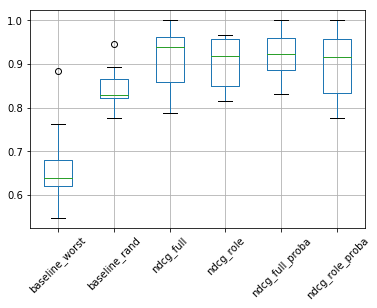

In [35]:
%matplotlib inline
pd.DataFrame(res)[['baseline_worst','baseline_rand','ndcg_full','ndcg_role','ndcg_full_proba','ndcg_role_proba']]\
    .boxplot(figsize=(5,8), rot=45)

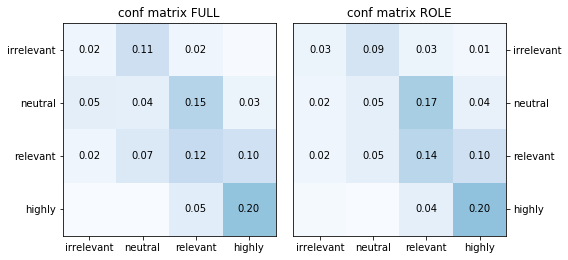

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm as colm
plt.figure(figsize=(8,5))
sub = plt.subplot(121)
normed = conf_matrix_full/conf_matrix_full.sum()
plt.imshow(normed, cmap=colm.Blues, vmax=0.5)
plt.title('conf matrix FULL')
sub.set_yticks([0,1,2,3])
sub.set_yticklabels(['irrelevant', 'neutral','relevant', 'highly'])
sub.set_xticks([0,1,2,3])
sub.set_xticklabels(['irrelevant', 'neutral','relevant', 'highly'])

for i in range(normed.shape[0]):
    for j in range(normed.shape[1]):
        v = normed.T[i][j]
        c='%.2f'%v if v>0.005 else ''
        sub.text(i, j, c, va='center', ha='center')



sub = plt.subplot(122)
normed = conf_matrix_role/conf_matrix_role.sum()
plt.imshow(normed, cmap=colm.Blues, vmax=0.5)
sub.yaxis.tick_right()
sub.set_yticks([0,1,2,3])
sub.set_yticklabels(['irrelevant', 'neutral','relevant', 'highly'])
sub.set_xticks([0,1,2,3])
sub.set_xticklabels(['irrelevant', 'neutral','relevant', 'highly'])

for i in range(normed.shape[0]):
    for j in range(normed.shape[1]):
        v = normed.T[i][j]
        c='%.2f'%v if v>0.01 else ''
        sub.text(i, j, c, va='center', ha='center')
        
plt.title('conf matrix ROLE')

plt.tight_layout()
plt.show()

# Save

affiliate 1145
agent 508
counterpart 1119
guarantor 335
insurer 473
issuer 1106
seller 520
servicer 614
trustee 2399
underwriter 559


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c90d7fac8>], dtype=object)

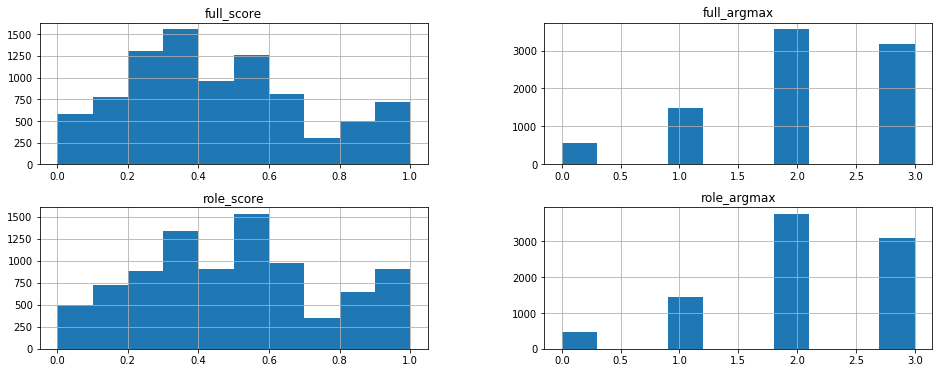

In [46]:
%matplotlib inline
def score_func(x, norm=True):
    kind = 'mulmax'
    if kind=='last':
        xx = x[-1]
    elif kind=='mulmax':
        xx = x.argmax(axis=1)*x.max(axis=1)
    elif kind=='maxadjust':
        xx = np.array([ai-xi[ai:ai+1].sum()+xi[ai+1:].sum() for xi,ai in zip(x,x.argmax(axis=1))])
    elif kind == '1234':
        xx = np.sum(x * np.array([1, 2, 3, 4]), axis=1)
    elif kind == '1246':
        xx = np.sum(x * np.array([1, 2, 4, 6]), axis=1)
    elif kind=='1245':
        xx = np.sum(x * np.array([1, 2, 4, 5]), axis=1)
    else:
        raise AttributeError('meh.')
        
    return (xx-xx.min())/(xx-xx.min()).max()

distribution_full = []
distribution_role = []
scores_full = []
scores_role = []

scored_full = []
scored_role = []

for role, frm in data.test.groupby('grp'):
    print(role, len(frm))
    fmpred, fmppred = fm.predict(frm)
    mpred, mppred = models[role].predict(frm)
    
    tmp = frm.copy()
    tmp['SCORE'] = score_func(fmppred)
    scored_full.append(tmp)
    
    tmp = frm.copy()
    tmp['SCORE'] = score_func(mppred)
    scored_role.append(tmp)
    
    distribution_full += list(fmpred)
    distribution_role += list(mpred)
    scores_full += list(score_func(fmppred))
    scores_role += list(score_func(mppred))
    
classifier = 'bow'
cols = ['SCORE','UNIQUE_ID', 'DOCUMENT_TYPE', 'FILER_NAME', 'FILER_CIK', 'FILING_INTERVAL', 'FILING_DATE', 
        'MENTIONED_FINANCIAL_ENTITY', 'ROLE', 'THREE_SENTENCES']


#pd.concat(scored_full).sort_values(by=['grp', 'SCORE'], 
#                                   ascending=[True, False])[cols].to_csv('scored_full_'+classifier+'.csv', index=False)
#pd.concat(scored_role).sort_values(by=['grp', 'SCORE'], 
#                                   ascending=[True, False])[cols].to_csv('scored_role_'+classifier+'.csv', index=False)

f, ax = plt.subplots(figsize=(16,6), nrows=2, ncols=2)
pd.DataFrame({'full_score':scores_full}).hist(ax=ax[0][0])
pd.DataFrame({'full_argmax':distribution_full}).hist(ax=ax[0][1])
pd.DataFrame({'role_score':scores_role}).hist(ax=ax[1][0])
pd.DataFrame({'role_argmax':distribution_role}).hist(ax=ax[1][1])

# Additional scoring

In [67]:
working_set = data.working.copy()[['INIQUE_ID', 'DOCUMENT_TYPE', 'FILER_NAME', 'FILER_CIK',
       'FILING_INTERVAL', 'FILING_DATE', 'MENTIONED_FINANCIAL_ENTITY', 'ROLE',
       'THREE_SENTENCES']]

In [87]:
pred_full = []
pred_role = []

classi = "emb"

for role, frm in data.test.groupby('grp'):
    print(role, len(frm))
    fmpred, fmppred = fm.predict(frm)
    mpred, mppred = models[role].predict(frm)
    
    pred_full += [{'index': i,
                   'score_full_'+classi: s, 
                   'pred_full_'+classi: "{:.5f}|{:.5f}|{:.5f}|{:.5f}".format(*p)} 
             for p, s, i in zip(fmppred, score_func(fmppred), frm.index)]
    pred_role += [{'index': i,
                   'score_role_'+classi: s, 
                   'pred_role_'+classi: "{:.5f}|{:.5f}|{:.5f}|{:.5f}".format(*p)} 
             for p, s, i in zip(mppred, score_func(mppred), frm.index)]

df = pd.DataFrame(pred_full, index =list(pd.DataFrame(pred_full)['index']))
working_set['score_full_'+classi] = df['score_full_'+classi]
working_set['pred_full_'+classi]  = df['pred_full_'+classi]

df = pd.DataFrame(pred_role, index =list(pd.DataFrame(pred_role)['index']))
working_set['score_role_'+classi] = df['score_role_'+classi]
working_set['pred_role_'+classi]  = df['pred_role_'+classi]

affiliate 1145
agent 508
counterpart 1119
guarantor 335
insurer 473
issuer 1106
seller 520
servicer 614
trustee 2399
underwriter 559


In [88]:
working_set.to_csv('scored_workingset.csv', index=False)

In [89]:
working_set.head()

,INIQUE_ID,DOCUMENT_TYPE,FILER_NAME,FILER_CIK,FILING_INTERVAL,FILING_DATE,MENTIONED_FINANCIAL_ENTITY,ROLE,THREE_SENTENCES,score_full_syn,...,score_role_vote,pred_role_vote,score_full_bow,pred_full_bow,score_role_bow,pred_role_bow,score_full_emb,pred_full_emb,score_role_emb,pred_role_emb
0,1831,10-K,Ally Financial Inc,40729,2015-FY,2/24/2016,Ally Bank,affiliate,"Furthermore, there is an “attribution rule” th...",0.369995,...,0.354949,0.13684|0.30976|0.37962|0.17378,0.038140,0.09593|0.17808|0.37014|0.35585,0.087432,0.27812|0.26936|0.35539|0.09713,0.056855,0.07855|0.27178|0.36381|0.28585,0.698725,0.13268|0.14744|0.29711|0.42276
1,1832,10-K,Ally Financial Inc,40729,2015-FY,2/24/2016,Ally,Affiliate,"For example, because Ally controls Ally Bank, ...",0.355088,...,0.365277,0.13742|0.30340|0.38787|0.17131,0.038140,0.09593|0.17808|0.37014|0.35585,0.087432,0.27812|0.26936|0.35539|0.09713,0.574718,0.08307|0.19761|0.35154|0.36777,0.291061,0.13572|0.14976|0.30190|0.41262
2,1833,10-K,Ally Financial Inc,40729,2015-FY,2/24/2016,Ally,underwriters,Proceeds from the offering amounted to $2.4 bi...,0.533333,...,0.630390,0.01442|0.03046|0.65094|0.30417,0.000000,0.12561|0.21594|0.36511|0.29334,0.604703,0.01850|0.04103|0.52575|0.41472,0.023048,0.08134|0.21448|0.35735|0.34683,0.570189,0.02373|0.04997|0.52544|0.40086
3,1834,10-K,Ally Financial Inc,40729,2015-FY,2/24/2016,Ally,Guarantors,The elimination entries set forth in the follo...,0.666667,...,0.970528,0.00000|0.05355|0.84677|0.09969,0.039948,0.09593|0.17808|0.37014|0.35585,1.000000,0.00000|0.04396|0.80675|0.14929,0.032523,0.07766|0.22671|0.35894|0.33669,0.955305,0.00000|0.07988|0.77360|0.14653
4,1835,10-K,Ally Financial Inc,40729,2015-FY,2/24/2016,Ally,Guarantors,The elimination entries set forth in the follo...,0.666667,...,0.998939,0.00000|0.03777|0.86372|0.09851,0.039948,0.09593|0.17808|0.37014|0.35585,1.000000,0.00000|0.04396|0.80675|0.14929,0.043275,0.07416|0.26273|0.36122|0.30189,0.867443,0.00000|0.12378|0.72757|0.14865


In [62]:
pd.DataFrame(pred_full, index =list(pd.DataFrame(pred_full)['index']))

,index,pred_full_syn,score_full_syn
0,0,0.00000|0.44501|0.55499|0.00000,0.369995
1,1,0.00000|0.46737|0.53263|0.00000,0.355088
15,15,0.05000|0.40000|0.05000|0.50000,0.500000
17,17,0.00000|0.15000|0.55000|0.30000,0.366667
21,21,0.09358|0.48014|0.27628|0.15000,0.160047
24,24,0.00000|0.07950|0.50307|0.41743,0.335380
26,26,0.08745|0.01255|0.10000|0.80000,0.800000
27,27,0.08745|0.01255|0.10000|0.80000,0.800000
28,28,0.09096|0.15000|0.65904|0.10000,0.439363
29,29,0.00000|0.10000|0.10000|0.80000,0.800000


# Experiment with scoring functions

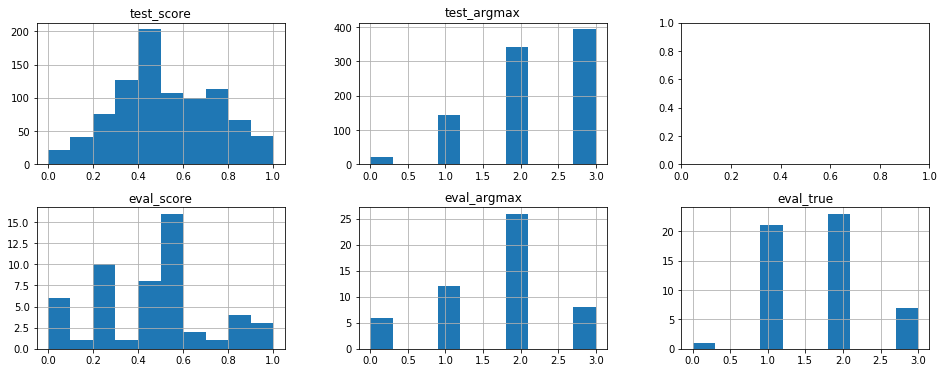

,test
count,900.000000
mean,0.522213
std,0.221250
min,0.000000
25%,0.384295
50%,0.489785
75%,0.698920
max,1.000000


In [206]:
%matplotlib inline
def score_func(x, norm=True):
    #return x.argmax(axis=1)
    #return np.sum(x * (np.ones_like(x)+ x.argmax(axis=1)), axis=1)
    #xx = ((x.argmax(axis=1))*x.argmax(axis=1)*x.max(axis=1))
    #xx= np.array([ai-xi[ai:ai+1].sum()+xi[ai+1:].sum() for xi,ai in zip(x,a)])
    #xx = x.argmax(axis=1)+x.max(axis=1)
    #xx = x.argmax(axis=1)*x.max(axis=1)*x.max(axis=1)
    #return xx
    kind = 'mulmax'
    if kind=='last':
        xx = x[-1]
    elif kind=='mulmax':
        xx = x.argmax(axis=1)*x.max(axis=1)
    elif kind=='maxadjust':
        xx = np.array([ai-xi[ai:ai+1].sum()+xi[ai+1:].sum() for xi,ai in zip(x,x.argmax(axis=1))])
    elif kind == '1234':
        xx = np.sum(x * np.array([1, 2, 3, 4]), axis=1)
    elif kind == '1246':
        xx = np.sum(x * np.array([1, 2, 4, 6]), axis=1)
    elif kind=='1245':
        xx = np.sum(x * np.array([1, 2, 4, 5]), axis=1)
    else:
        raise AttributeError('meh.')
        
    return (xx-xx.min())/(xx-xx.min()).max()

#pred, ppred = fm.predict(data.test)
#epred, eppred = fm.predict(data.eval)

f, ax = plt.subplots(figsize=(16,6), nrows=2, ncols=3)
pd.DataFrame({'test_score':score_func(ppred)}).hist(ax=ax[0][0])
pd.DataFrame({'test_argmax':pred}).hist(ax=ax[0][1])
pd.DataFrame({'eval_true':data.get_target(frm='eval')}).hist(ax=ax[1][2])
pd.DataFrame({'eval_score':score_func(eppred)}).hist(ax=ax[1][0])
pd.DataFrame({'eval_argmax':epred}).hist(ax=ax[1][1])
plt.show()
pd.DataFrame({'test':score_func(ppred, norm=False)}).describe()
#pd.DataFrame({'eval':score_func(eppred)})
#pd.DataFrame({'ppred':score_func(ppred), 'eppred':score_func(eppred)}).describe()